<a href="https://colab.research.google.com/github/joaoBernardinoo/avoid-obstacle-collision/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [17]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [3]:
# @title Plot

def evaluate_and_plot_prediction(y_test, y_pred, n):
    """
    Calculates errors and generates plots to evaluate prediction performance.

    Args:
        y_test (np.ndarray): Array of real values.
        y_pred (np.ndarray): Array of predicted values.
    """
    errors = y_test - y_pred

    # Calculate metrics
    mae = np.mean(np.abs(errors))
    accuracy = np.mean(np.abs(errors) < 0.2)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Gráfico 1: Predição vs Valor Real
    plt.subplot(131)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([-2, 2], [-2, 2], 'r--', label='Predição Perfeita')
    plt.plot([-2, 2], [2, -2], 'r--')

    plt.title(f'Predição vs Valor Real\ninput size: {n}')
    plt.xlabel('Valor Real')
    plt.ylabel('Predito')
    plt.grid(True)
    plt.legend()

    # Gráfico 2: Distribuição dos Erros
    plt.subplot(132)
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(0, color='r', linestyle='--')
    plt.title(f'Distribuição dos Erros\nMAE: {mae:.4f}')
    plt.xlabel('Erro (Real - Predito)')
    plt.ylabel('Frequência')
    plt.grid(True)

    # Gráfico 3: Valores Reais vs Preditos
    plt.subplot(133)
    sorted_idx = np.argsort(y_test)
    plt.plot(y_test[sorted_idx], label='Valor Real')
    plt.plot(y_pred[sorted_idx], 'r--', alpha=0.7, label='Predição')
    plt.title(f'Comparação Direta\nAcurácia (erro < 0.1): {accuracy:.2%}')
    plt.xlabel('Amostras Ordenadas')
    plt.ylabel('Valor')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Avaliação de desempenho
    print(f"\nErro Médio Absoluto (MAE): {mae:.4f}")
    print(f"Acurácia (erro < 0.1): {accuracy:.2%}")

In [4]:
import numpy as np

from sklearn.model_selection import train_test_split

# Parameters
n = 20  # Number of input variables (min(a₁, a₂, ..., aₙ))
num_samples = 10000  # Training data size
input_range = (-3.14, 3.14)  # Input values range


# Funções auxiliares (assumindo que já estão definidas no seu ambiente)
# Exemplo de implementação para que o código seja executável e compreensível:

def closest_to_zero(arr):
    """
    Retorna o valor no array mais próximo de zero.
    Em caso de empate (dois valores com o mesmo valor absoluto, mas sinais diferentes),
    prioriza o valor positivo.
    """
    if arr.size == 0:
        return None

    # 1. Calcula o valor absoluto de todos os elementos
    abs_arr = np.abs(arr)

    # 2. Encontra o menor valor absoluto presente no array
    min_abs_val = np.min(abs_arr)

    # 3. Identifica todos os valores originais que possuem esse menor valor absoluto
    # Isso lida com casos como [-1, 1], [-0.5, 0.5], ou até mesmo apenas [-1] ou apenas [1]
    candidates = arr[abs_arr == min_abs_val]

    # 4. Verifica a regra de desempate:
    # Se o valor mais próximo de zero for 0, então 0 é a resposta.
    if min_abs_val == 0:
        return 0

    # Verifica se há algum valor positivo entre os candidatos
    # Por exemplo, se candidates é [-1, 1], positive_candidates será [1]
    positive_candidates = candidates[candidates > 0]

    if positive_candidates.size > 0:
        # Se houver pelo menos um candidato positivo (e ele já é o 'min_abs_val'),
        # retorna esse valor. Como todos os 'positive_candidates' teriam o mesmo
        # valor absoluto mínimo e seriam positivos, 'np.min' nele retornará o próprio valor.
        # Isso resultará no valor positivo (ex: 1)
        return np.min(positive_candidates)
    else:
        # Se não houver candidatos positivos (ou seja, todos os candidatos são negativos,
        # como em [-2, -1, -3] onde o candidato é apenas [-1]),
        # retorna o valor negativo. np.max aqui retornará o valor negativo mais próximo de zero (ex: -1).
        return np.max(candidates)  # Isso resultará no valor negativo (ex: -1)

In [5]:
import numpy as np


def generate_data(n, num_samples, target_y_values=None, max_other_magnitude=5.0):
    """
    Gera dados n-dimensionais (X) e seus valores closest_to_zero (Y).

    Esta versão garante que:
    1. Os valores Y são derivados de 'target_y_values'.
    2. Os elementos na primeira metade de cada linha de X (0 a n/2-1) são negativos.
    3. Os elementos na segunda metade de cada linha de X (n/2 a n-1) são positivos.

    Args:
        n (int): Número de features em cada amostra. **Deve ser um número par.**
        num_samples (int): Número de amostras a gerar.
        target_y_values (np.array, optional): Um array 1D com os valores Y desejados.
                                              Seu comprimento deve ser 'num_samples'.
        max_other_magnitude (float): Magnitude absoluta máxima para os outros elementos em X.
                                     Deve ser maior que o valor absoluto máximo esperado em 'target_y_values'.

    Returns:
        tuple: (X, Y) arrays NumPy.
    """
    if n % 2 != 0:
        raise ValueError(
            "O número de features (n) deve ser um número par para a restrição de metade negativa/metade positiva.")

    X = np.zeros((num_samples, n))
    Y_actual = np.zeros(num_samples)

    if target_y_values is None or len(target_y_values) != num_samples:
        raise ValueError(
            "target_y_values deve ser fornecido e ter o mesmo comprimento que num_samples para a distribuição uniforme de Y.")

    half_n = n // 2

    for i in range(num_samples):
        y_val = target_y_values[i]

        # Determina a metade válida para inserir o y_val com base no seu sinal
        if y_val < 0:
            # y_val é negativo, deve ser inserido na primeira metade (valores negativos)
            insert_idx = np.random.randint(0, half_n)
        elif y_val > 0:
            # y_val é positivo, deve ser inserido na segunda metade (valores positivos)
            insert_idx = np.random.randint(half_n, n)
        else:  # y_val == 0
            # Se y_val é zero, pode ser inserido em qualquer metade; escolhe aleatoriamente
            insert_idx = np.random.randint(0, n)

        X[i, insert_idx] = y_val
        # O valor Y real para esta amostra é o y_val que definimos
        Y_actual[i] = y_val

        # Preenche as outras posições da linha de X, respeitando a regra de sinal por metade
        for j in range(n):
            if j == insert_idx:
                continue  # Pula a posição onde y_val já foi inserido

            # A magnitude deve ser estritamente maior que abs(y_val)
            min_mag_other = np.abs(y_val) + 1e-6

            # Garante que a magnitude gerada esteja dentro dos limites permitidos
            current_max_mag = max_other_magnitude
            if min_mag_other >= current_max_mag:
                # Caso onde min_mag_other é muito grande; faz um ajuste para gerar um valor
                magnitude = np.random.uniform(
                    min_mag_other, min_mag_other + 1.0)
            else:
                magnitude = np.random.uniform(min_mag_other, current_max_mag)

            # Atribui o sinal com base na metade do array
            if j < half_n:  # Primeira metade, deve ser negativa
                X[i, j] = -magnitude
            else:  # Segunda metade, deve ser positiva
                X[i, j] = magnitude

    return X, Y_actual


# A função generate_data2 não precisa ser modificada novamente,
# pois ela já chama a função generate_data e lida com a distribuição uniforme de Y e os lotes.
# A única mudança necessária é a verificação de 'n' par no início.
def generate_data2(n, num_samples_total, y_uniform_range=(-2.0, 2.0), x_max_other_magnitude=5.0):
    """
    Gera um dataset onde os valores de 'closest_to_zero' (y) são uniformemente distribuídos
    dentro de uma faixa especificada, e cada linha de X adere à restrição de
    metade negativa/metade positiva.

    Args:
        n (int): Número de features em cada amostra. **Deve ser um número par.**
        num_samples_total (int): Número total de amostras a serem geradas para o dataset.
        y_uniform_range (tuple): A faixa (mín, máx) para a distribuição uniforme dos valores de y.
        x_max_other_magnitude (float): Magnitude absoluta máxima para os outros elementos em X.
                                       Deve ser escolhida de forma que seja geralmente maior
                                       que o valor absoluto máximo na faixa de 'y_uniform_range'.
    Returns:
        tuple: (X, y) arrays concatenados com y uniformemente distribuído e X estruturado.
    """
    if n % 2 != 0:
        raise ValueError(
            "O número de features (n) deve ser um número par para a restrição de metade negativa/metade positiva.")

    # 1. Gera todos os valores 'y' alvo uniformemente para o dataset completo
    y_uniform_all = np.random.uniform(
        y_uniform_range[0], y_uniform_range[1], num_samples_total)
    # Embaralha para garantir aleatoriedade entre os sub-lotes
    np.random.shuffle(y_uniform_all)

    X_list = []
    y_list = []

    num_batches = 4  # Mantém a estrutura original de 4 lotes
    num_samples_per_batch = num_samples_total // num_batches

    if num_samples_total % num_batches != 0:
        print(
            f"Aviso: num_samples_total ({num_samples_total}) não é perfeitamente divisível por {num_batches}. O último lote terá um tamanho diferente.")

    current_idx = 0
    for i in range(num_batches):
        batch_size = num_samples_per_batch
        if i == num_batches - 1:
            batch_size = num_samples_total - current_idx

        y_batch_targets = y_uniform_all[current_idx: current_idx + batch_size]

        # Chama a função generate_data (agora modificada) para criar as linhas X
        # que correspondem aos y_batch_targets E aderem à nova restrição de sinal
        x_batch, y_actual_batch = generate_data(n, len(y_batch_targets),
                                                target_y_values=y_batch_targets,
                                                max_other_magnitude=x_max_other_magnitude)
        X_list.append(x_batch)
        y_list.append(y_actual_batch)

        current_idx += batch_size

    X_combined = np.concatenate(X_list)
    y_combined = np.concatenate(y_list)

    return X_combined, y_combined

In [6]:
X, y = generate_data2(n, num_samples, input_range)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Sklearn


In [19]:
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "adaptive",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {"solver": "adam", "learning_rate_init": 0.01},
]

In [20]:

# Transformar em problema multiclasse
y_train_class = np.argmin(np.abs(X_train), axis=1)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 50),
                    activation='relu', **params[-1],
                    verbose=True, max_iter=1000, random_state=42,
                    early_stopping=True, n_iter_no_change=50)
mlp.fit(X_train, y_train_class)

Iteration 1, loss = 2.88840203
Validation score: 0.131250
Iteration 2, loss = 2.54513678
Validation score: 0.211250
Iteration 3, loss = 2.35483365
Validation score: 0.201250
Iteration 4, loss = 2.25926103
Validation score: 0.240000
Iteration 5, loss = 2.16856065
Validation score: 0.273750
Iteration 6, loss = 2.07102441
Validation score: 0.243750
Iteration 7, loss = 2.07340431
Validation score: 0.295000
Iteration 8, loss = 1.96584729
Validation score: 0.321250
Iteration 9, loss = 1.90120789
Validation score: 0.341250
Iteration 10, loss = 1.82547448
Validation score: 0.355000
Iteration 11, loss = 1.72443386
Validation score: 0.396250
Iteration 12, loss = 1.69875140
Validation score: 0.395000
Iteration 13, loss = 1.62171279
Validation score: 0.396250
Iteration 14, loss = 1.57742776
Validation score: 0.435000
Iteration 15, loss = 1.48069576
Validation score: 0.377500
Iteration 16, loss = 1.47523328
Validation score: 0.467500
Iteration 17, loss = 1.40259593
Validation score: 0.428750
Iterat

,hidden_layer_sizes,"(100, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.01
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


/home/dino/Documents/avoid-obstacle-collision/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752635058.765609   68337 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2498 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-07-16 00:04:19.632862: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfi

In [33]:
def text_callable(layer_idx, layer):
    """
    Custom text callable function for visualkeras.layered_view()
    
    Args:
        layer_idx: Index of the layer in the model (ignoring certain layers)
        layer: The actual layer object
        
    Returns:
        tuple: (text_to_display, draw_above)
               text_to_display: String to show for this layer
               draw_above: Boolean whether to draw text above the layer box
    """
    # Default values
    text = layer.name
    draw_above = False  # Default to drawing below
    
    # Customize text based on layer type
    if isinstance(layer, tf.keras.layers.Conv2D):
        text = f"Conv2D\n{layer.filters} filters\nkernel {layer.kernel_size}"
        draw_above = True
    elif isinstance(layer, tf.keras.layers.MaxPooling2D):
        text = f"MaxPool\npool {layer.pool_size}"
    elif isinstance(layer, tf.keras.layers.Dense):
        text = f"Dense\n{layer.units} units"
        draw_above = True
    elif isinstance(layer, tf.keras.layers.Dropout):
        text = f"Dropout\nrate {layer.rate}"
    elif isinstance(layer, tf.keras.layers.Flatten):
        text = "Flatten"
    
    return text, draw_above

# Example usage:
from tensorflow.keras.utils import plot_model
import visualkeras

# Create your model
model = create_ball_angle_cnn(input_channels=1)

# Visualize with custom text
visualkeras.layered_view(
    model,
    text_callable=text_callable,
    legend=True,  # Optional: show legend
    font=tf.keras.utils.get_file('arial.ttf', 'https://github.com/ultralytics/yolov5/releases/download/v1.0/arial.ttf')  # Optional: specify font
)

/home/dino/Documents/avoid-obstacle-collision/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


773236/773236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


AttributeError: 'str' object has no attribute 'getbbox'

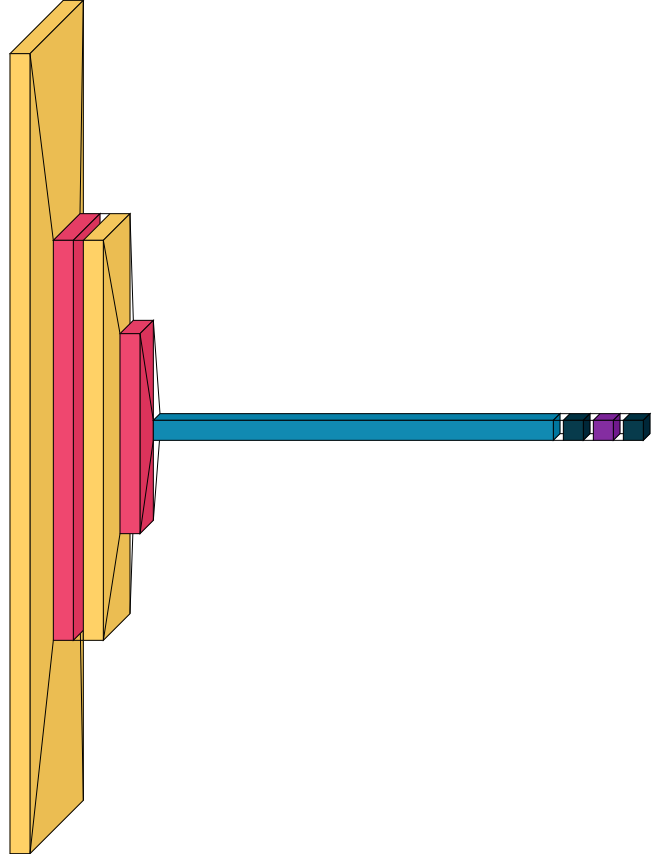

In [ ]:
import visualkeras

visualkeras.layered_view(model, text_callable=text_callable)  # font is optional!


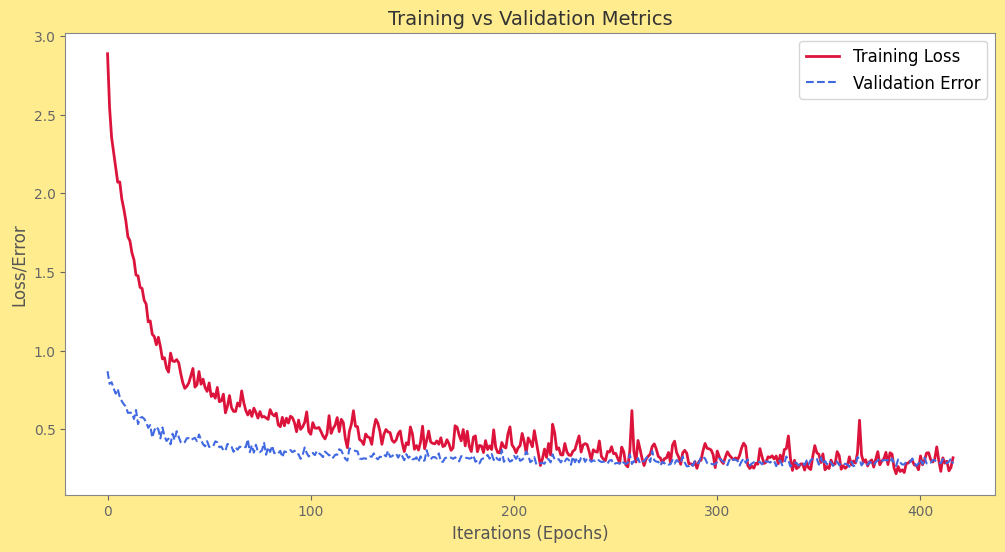

In [ ]:
plt.figure(figsize=(12, 6), facecolor='#FFEC8F') # Light Yellow Background

# Training Loss (Red-inspired color)
plt.plot(mlp.loss_curve_, label='Training Loss', linewidth=2, color='#DC143C') # Crimson

# Validation Loss (if early_stopping=True)
if hasattr(mlp.validation_scores_, '__len__'):
    # Convert validation accuracy to error for comparable scale
    validation_error = [1 - score for score in mlp
    .validation_scores_] # type: ignore
    plt.plot(validation_error, label='Validation Error', linestyle='--', color='#4169E1') # Royal Blue

plt.title('Training vs Validation Metrics', fontsize=14, color='#333333') # Dark Gray Title
plt.xlabel('Iterations (Epochs)', fontsize=12, color='#555555') # Medium Gray Label
plt.ylabel('Loss/Error', fontsize=12, color='#555555') # Medium Gray Label
plt.legend(fontsize=12, facecolor='white', edgecolor='#CCCCCC') # White legend with light gray border
plt.grid(True, linestyle='--', alpha=0.7, color='white') # White grid
plt.gca().spines['bottom'].set_color('#888888') # Light Gray spines
plt.gca().spines['top'].set_color('#888888')
plt.gca().spines['left'].set_color('#888888')
plt.gca().spines['right'].set_color('#888888')
plt.gca().tick_params(axis='x', colors='#666666') # Medium-dark gray ticks
plt.gca().tick_params(axis='y', colors='#666666')

plt.show()

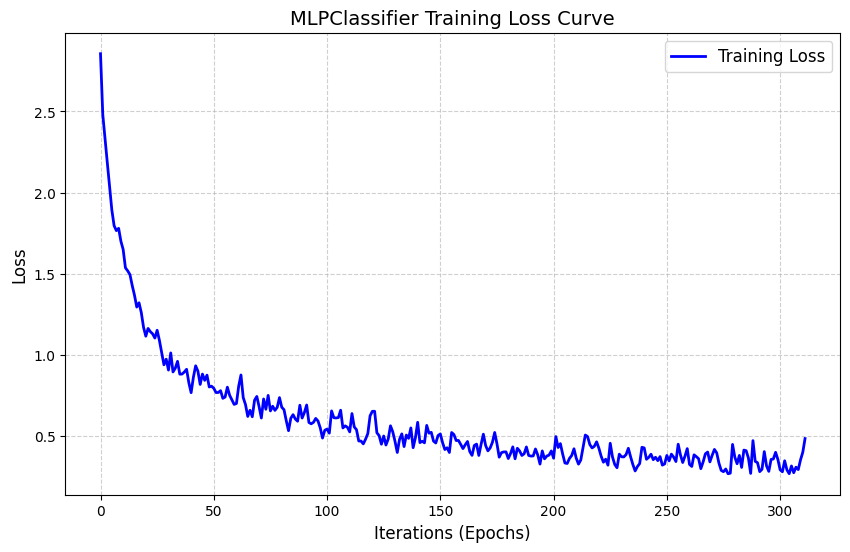

In [ ]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_, label='Training Loss', color='blue', linewidth=2)
plt.title('MLPClassifier Training Loss Curve', fontsize=14)
plt.xlabel('Iterations (Epochs)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [18]:
# Recuperar a predição
predicted_indices = mlp.predict(X_test)
y_pred = X_test[np.arange(len(X_test)), predicted_indices]

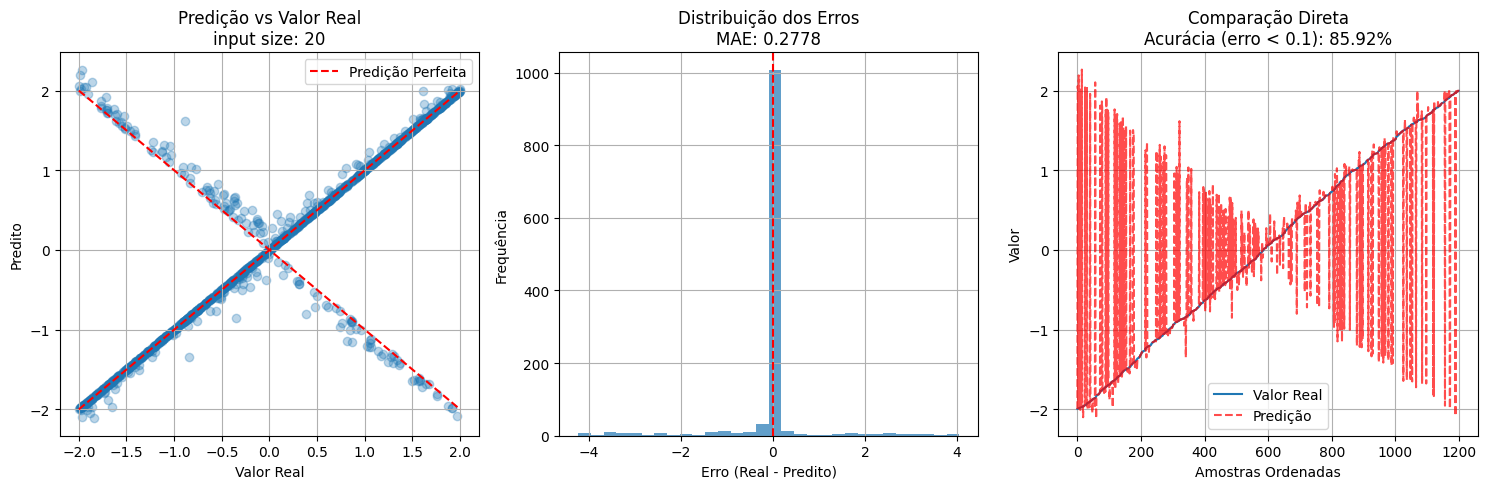


Erro Médio Absoluto (MAE): 0.2778
Acurácia (erro < 0.1): 85.92%


In [ ]:
# Example usage of the function with the existing variables
evaluate_and_plot_prediction(y_test, y_pred, n)

In [ ]:
joblib.dump(mlp, "controllers/robot/mlp.pkl")

['mlp.pkl']

In [ ]:

def plot_history(history):
    # Plot training & validation loss
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot accuracy if available
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'],
                     label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.show()

## tensorflow


In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Reshape, GlobalAveragePooling1D, MultiHeadAttention, Input, Lambda, Conv1D, Dense, Concatenate, Layer
from tensorflow.keras.optimizers import Adam

2025-07-14 01:53:28.445689: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 01:53:28.448394: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 01:53:28.455042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752468808.466890  150282 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752468808.470098  150282 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752468808.478919  150282 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
class MinFinderLossLayer(Layer):
    def call(self, inputs):
        input_values, scores = inputs
        abs_values = tf.abs(input_values)
        true_min_indices = tf.argmin(abs_values, axis=1)
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=true_min_indices,
                logits=scores
            )
        )
        self.add_loss(loss)
        return scores  # Pass through the scores

In [ ]:
def create_model(max_length=20):
    input_layer = Input(shape=(max_length,))
    abs_values = Lambda(lambda x: tf.abs(x))(input_layer)
    x = Concatenate()([input_layer, abs_values])
    x = Reshape((max_length*2, 1))(x)

    # Dilated convolutions for wider receptive field
    x = Conv1D(64, 3, dilation_rate=1, activation='relu', padding='same')(x)
    x = Conv1D(64, 3, dilation_rate=2, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)

    scores = Dense(max_length)(x)
    model = Model(input_layer, MinFinderLossLayer()([input_layer, scores]))
    model.compile(optimizer=Adam(0.001))
    return model


model = create_model(max_length=n)

E0000 00:00:1752468847.391345  150282 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752468847.395408  150282 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:

def create_model(max_length=20):
    input_layer = Input(shape=(max_length,))

    # Create absolute values and combine with original
    abs_values = Lambda(lambda x: tf.abs(x))(input_layer)
    # Shape: (batch, max_length*2)
    merged = Concatenate(axis=-1)([input_layer, abs_values])

    # Reshape to 3D for Conv1D: (batch, steps=max_length*2, channels=1)
    x = Reshape((max_length*2, 1))(merged)

    # Feature extraction
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)

    # Multi-head attention (4 heads, 16-dim keys)
    att = MultiHeadAttention(num_heads=4, key_dim=16)(x, x)  # Self-attention
    x = Concatenate(axis=-1)([x, att])  # Combine conv and attention features

    # Global pooling and scoring
    x = GlobalAveragePooling1D()(x)
    scores = Dense(max_length, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=MinFinderLossLayer()
                  ([input_layer, scores]))
    model.compile(optimizer=Adam(0.001))
    return model


# Recreate and retrain your model
model = create_model(max_length=n)
history = model.fit(x=X_train, y=None, epochs=100, batch_size=128)

E0000 00:00:1752463694.669007   34421 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752463694.671472   34421 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.0032
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9922
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9871
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9902
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9871
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9865
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9864
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9854
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9819
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9853
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9850
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9801
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9699
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9808
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9531
Epoc

In [ ]:
history = model.fit(x=X_train, y=None, epochs=200, batch_size=64)

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0050
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9898
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9851
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9820
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9694
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9597
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9451
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9217
Epoch 9/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8924
Epoch 10/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8503
Epoch 11/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8131
Epoch 12/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7655
Epoch 13/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7139
Epoch 14/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6776
Epoch 15/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6281
Epoc

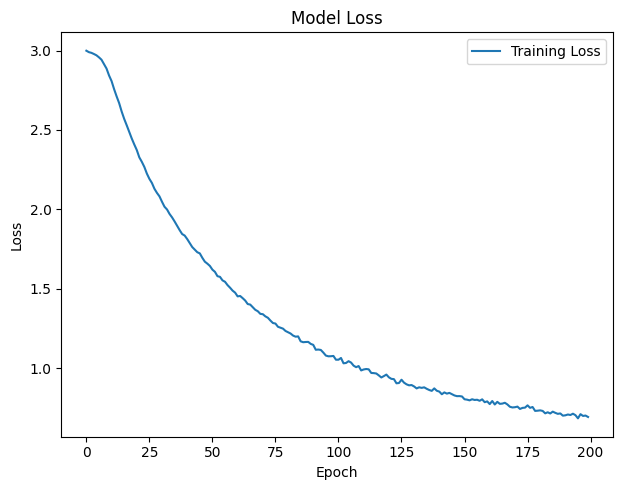

In [ ]:
plot_history(history)

In [ ]:
def predict_batch(model, input_arrays):
    """
    Predict on a batch of arrays for better efficiency
    """
    # Convert to numpy array
    input_batch = np.array(input_arrays)

    # Get raw scores for all samples at once
    scores = model.predict(input_batch, verbose=0)

    # Print shape of scores and predicted_indices for debugging
    print("Shape of scores:", scores.shape)

    # Get indices of the element with the highest score (which corresponds to the predicted index of the closest to zero value)
    predicted_indices = np.argmax(scores, axis=1)
    print("Predicted indices (first 10):", predicted_indices[:10])
    print("Max predicted index:", np.max(predicted_indices))

    # Select the corresponding values from the original input arrays
    y_pred = np.array([arr[idx]
                      for arr, idx in zip(input_arrays, predicted_indices)])

    return y_pred


# Usage
y_pred = predict_batch(model, X_test)

Shape of scores: (1200, 20)
Predicted indices (first 10): [ 6  6 13  5 11  9 17 12  6 17]
Max predicted index: 19


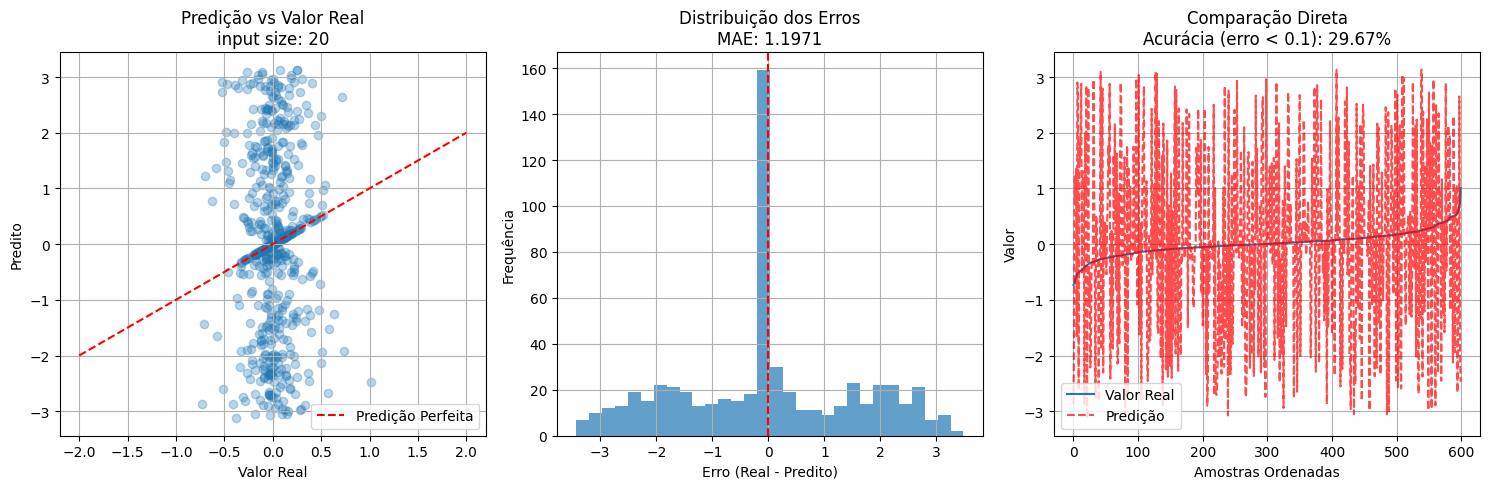


Erro Médio Absoluto (MAE): 1.1971
Acurácia (erro < 0.1): 29.67%


In [ ]:
evaluate_and_plot_prediction(y_test, y_pred, n)

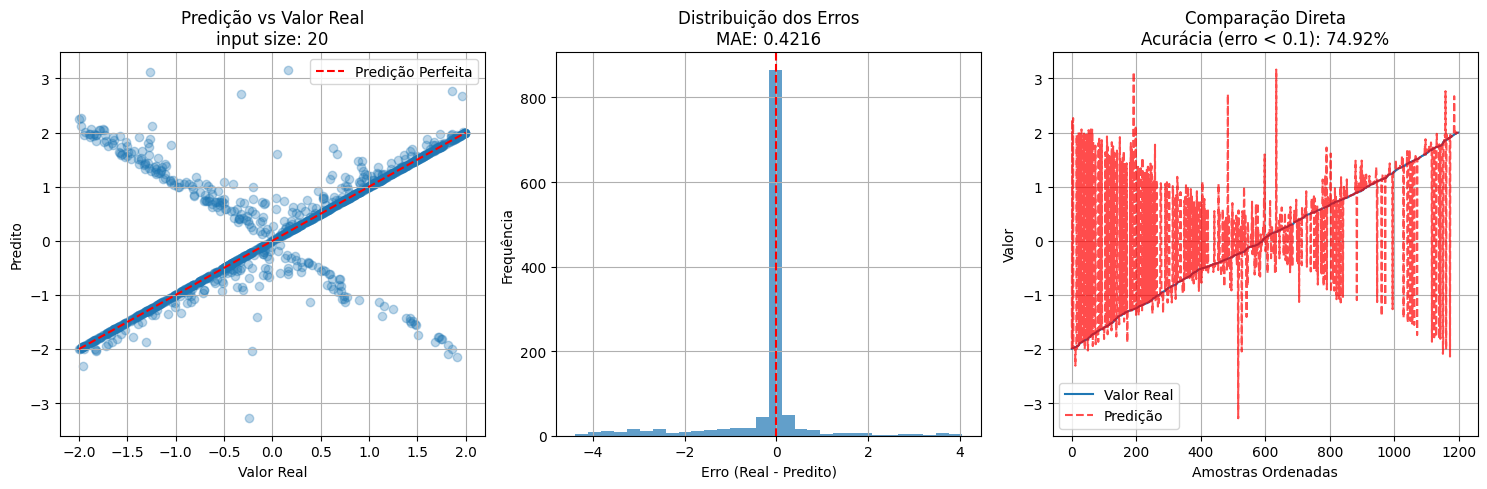


Erro Médio Absoluto (MAE): 0.4216
Acurácia (erro < 0.1): 74.92%


In [ ]:

evaluate_and_plot_prediction(y_test, y_pred, n)